# Website Classification

The goal is be able to classify a website into a category. This will be used when SearchGar's Crawler is crawling and saving the website data and when a user is searching for something.

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

In [4]:
dataset=pd.read_csv('./website_classification.csv')
dataset.shape

(1408, 4)

In [5]:
dataset.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [6]:
df = dataset[['website_url','cleaned_website_text','Category']].copy()
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [7]:
pd.DataFrame(df.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

In [8]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [9]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
213,Sports,4
398,Photography,5
586,Law and Government,6
670,Health and Fitness,7
768,Games,8
810,E-Commerce,9


In [10]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(df.cleaned_website_text).toarray()

labels = df.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1408 text is represented by 18865 features (TF-IDF score of unigrams and bigrams)


In [12]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Adult:
  * Most Correlated Unigrams are: porn, xxx, erotic
  * Most Correlated Bigrams are: sex toys, sex toy, erotic story

==> Business/Corporate:
  * Most Correlated Unigrams are: accounting, investment, banking
  * Most Correlated Bigrams are: home products, real estate, online banking

==> Computers and Technology:
  * Most Correlated Unigrams are: file, windows, software
  * Most Correlated Bigrams are: programming language, web hosting, source code

==> E-Commerce:
  * Most Correlated Unigrams are: accessories, accessory, shipping
  * Most Correlated Bigrams are: grocery shopping, add cart, free shipping

==> Education:
  * Most Correlated Unigrams are: biology, university, chemistry
  * Most Correlated Bigrams are: earth science, periodic table, open access

==> Food:
  * Most Correlated Unigrams are: cake, recipes, recipe
  * Most Correlated Bigrams are: order online, instant pot, gluten free

==> Forums:
  * Most Correlated Unigrams are: redirect, answers, forums
  * Mos

In [13]:
X = df['cleaned_website_text']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [14]:
y_train.value_counts()

Streaming Services                 86
Education                          81
E-Commerce                         81
Health and Fitness                 79
Games                              78
Travel                             76
Business/Corporate                 75
Sports                             75
Computers and Technology           74
Law and Government                 68
Social Networking and Messaging    66
News                               64
Photography                        64
Food                               63
Adult                              14
Forums                             12
Name: Category, dtype: int64

In [16]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GaussianNB()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.719858
1,RandomForestClassifier,1,0.751773
2,RandomForestClassifier,2,0.716312
3,RandomForestClassifier,3,0.736655
4,RandomForestClassifier,4,0.679715
5,LinearSVC,0,0.858156
6,LinearSVC,1,0.932624
7,LinearSVC,2,0.939716
8,LinearSVC,3,0.903915
9,LinearSVC,4,0.879004


In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
GaussianNB,0.728651,0.055462
LinearSVC,0.902683,0.034687
MultinomialNB,0.852979,0.034688
RandomForestClassifier,0.720863,0.027017


In [18]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
calibrated_svc = CalibratedClassifierCV(base_estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

0.9403409090909091


In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test,predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= df['Category'].unique()))

				CLASSIFICATIION METRICS

                                 precision    recall  f1-score   support

                         Travel       1.00      0.97      0.98        30
Social Networking and Messaging       0.83      0.71      0.77        14
                           News       0.92      0.88      0.90        25
             Streaming Services       1.00      0.92      0.96        26
                         Sports       0.93      0.96      0.95        28
                    Photography       0.96      0.92      0.94        25
             Law and Government       0.94      1.00      0.97        16
             Health and Fitness       0.93      0.93      0.93        29
                          Games       0.92      0.96      0.94        25
                     E-Commerce       0.97      0.97      0.97        30
                         Forums       0.00      0.00      0.00         2
                           Food       0.92      1.00      0.96        24
                     

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1

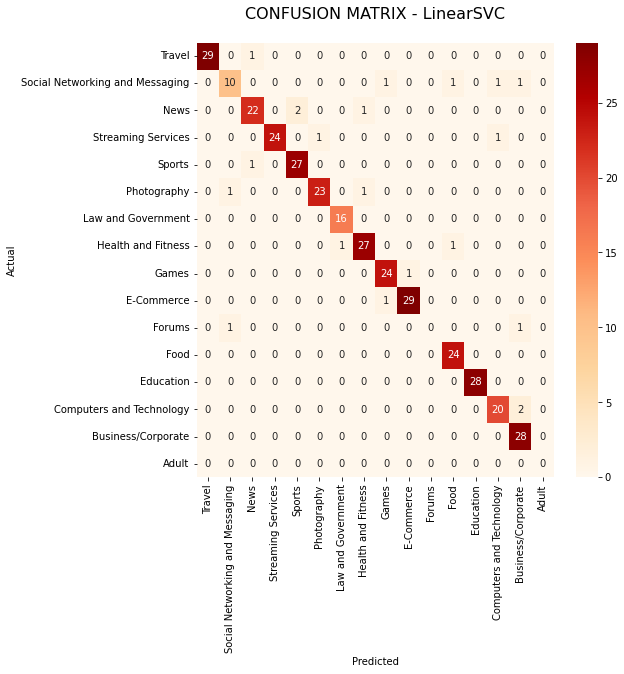

In [20]:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [21]:
model.fit(features, labels)

N = 4
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Category))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Adult':
  * Top unigrams: bdsm, sex, erotic, bondage
  * Top bigrams: erotic story, sex toy, sex toys, live sex

==> 'Business/Corporate':
  * Top unigrams: investment, client, company, business
  * Top bigrams: real estate, audio visual, year experience, site work

==> 'Computers and Technology':
  * Top unigrams: software, file, web, windows
  * Top bigrams: source code, web hosting, come soon, easy use

==> 'E-Commerce':
  * Top unigrams: shipping, grocery, item, gift
  * Top bigrams: free shipping, gift card, grocery shopping, add cart

==> 'Education':
  * Top unigrams: university, science, student, chemistry
  * Top bigrams: open access, multiple choice, annual meeting, state university

==> 'Food':
  * Top unigrams: recipe, cake, restaurant, tasty
  * Top bigrams: order online, gluten free, home menu, breakfast lunch

==> 'Forums':
  * Top unigrams: forums, forum, answers, google
  * Top bigrams: share knowledge, mon dec, hour ago, post hour

==> 'Games':
  * Top unigrams:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1 = CalibratedClassifierCV(base_estimator = m,
                                        cv = "prefit").fit(tfidf_vectorizer_vectors, y_train)

In [35]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os

class Crawler:
    def __init__(self, url):
        self.url = url
    
    def visit_url(self):    
        content = requests.get(self.url,timeout=60).content        
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_url": self.url,
            "website_name": self.get_website_name(self.url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+
            self.get_html_heading_tags(soup)+ self.get_text_content(soup)
        }        
        return pd.Series(result)
    
    def get_website_name(self,url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(self.url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

import spacy as sp
from collections import Counter
import en_core_web_sm
import re

nlp = en_core_web_sm.load()

def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 


In [45]:
website='https://openai.com'
crawler = Crawler(website)
web=dict(crawler.visit_url())
text=(clean_text(web['website_text']))
t=fitted_vectorizer.transform([text])
print(id_to_category[m1.predict(t)[0]])
data=pd.DataFrame(m1.predict_proba(t)*100,columns=df['Category'].unique())
data=data.T
data.columns=['Probability']
data.index.name='Category'
a=data.sort_values(['Probability'],ascending=False)
a['Probability']=a['Probability'].apply(lambda x:round(x,2))

Computers and Technology


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


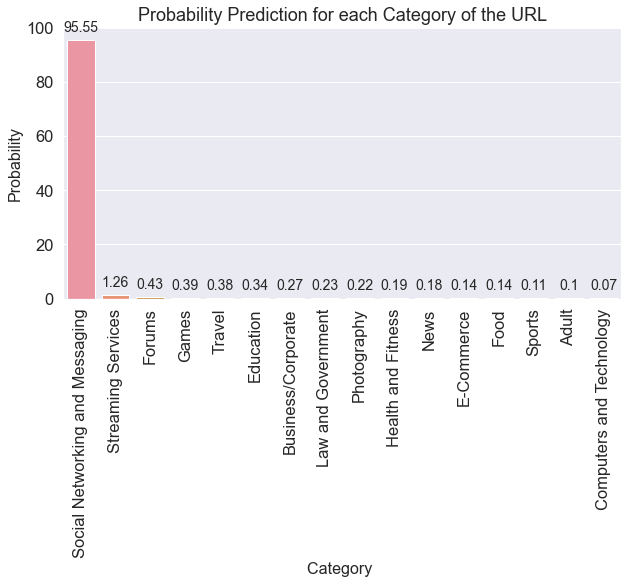

In [43]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(10,5))
i=list(a.index)
ax= sns.barplot(i,a['Probability'])

plt.title("Probability Prediction for each Category of the URL", fontsize=18)
plt.ylabel('Probability', fontsize=16)
plt.xlabel('Category ', fontsize=16)

#adding the text labels
rects = ax.patches
labels = a['Probability']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.show()